# Libraries

In [1]:
%matplotlib inline

import os
import time
import sys
import numpy as np
from glob import glob

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm_notebook as tqdm

from dataset_weight_test import TestImages as TestImages_Weight
from dataset_test import TestImages as TestImages_Height

from network import UNet as UNet_H
from network_weight import UNet as UNet_W
from loss import dice_coef, dice_loss
import matplotlib.pyplot as plt

In [2]:
torch.cuda.set_device(0)
torch.cuda.current_device()

0

## Model Performance on Height Estimation

Additional training after nearly 45th epoch by decrasing learning rate.

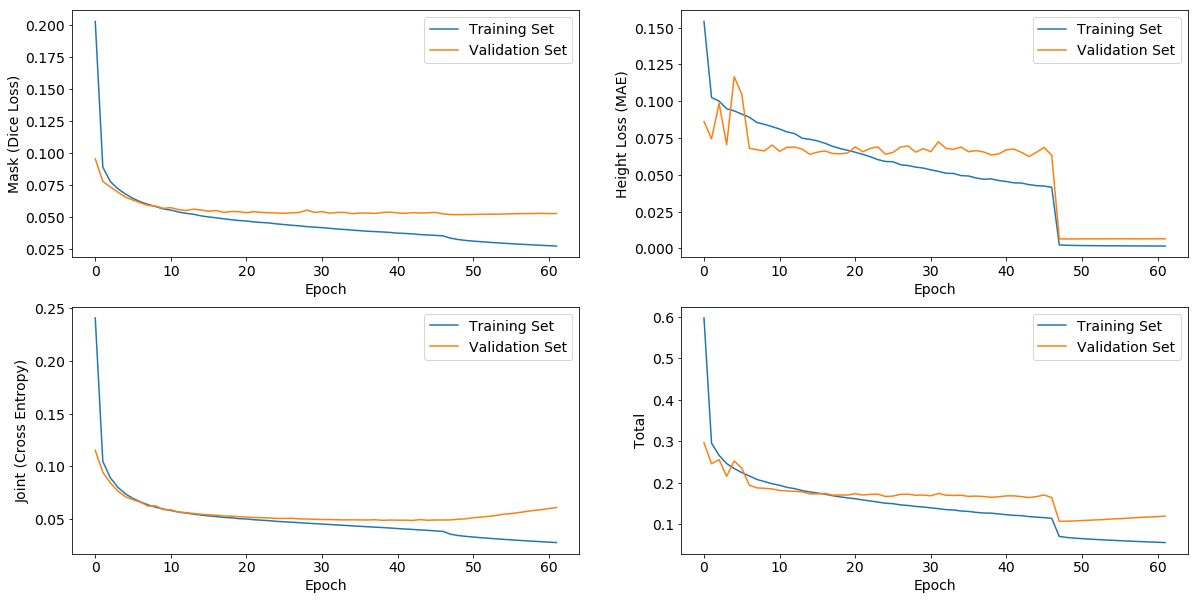

In [3]:
f, ax = plt.subplots(2,2, figsize=(20,10))
ax = ax.ravel()

labels = ['Mask (Dice Loss)', 'Height Loss (MAE)', 'Joint (Cross Entropy)', 'Total']

for i, l in enumerate(glob('logs/IMDB_MODEL_07102019_054512/t_*')):
    ax[i].plot(np.load(l), label='Training Set')
    ax[i].plot(np.load(l.replace('t_', 'v_')), label='Validation Set')
    ax[i].legend(fontsize=14)
    ax[i].set_ylabel(labels[i], fontsize=14)
    ax[i].set_xlabel('Epoch', fontsize=14)
    ax[i].tick_params(labelsize=14)

## Model Performance on Weight Estimation

Additional training after nearly 30th epoch by decrasing learning rate.

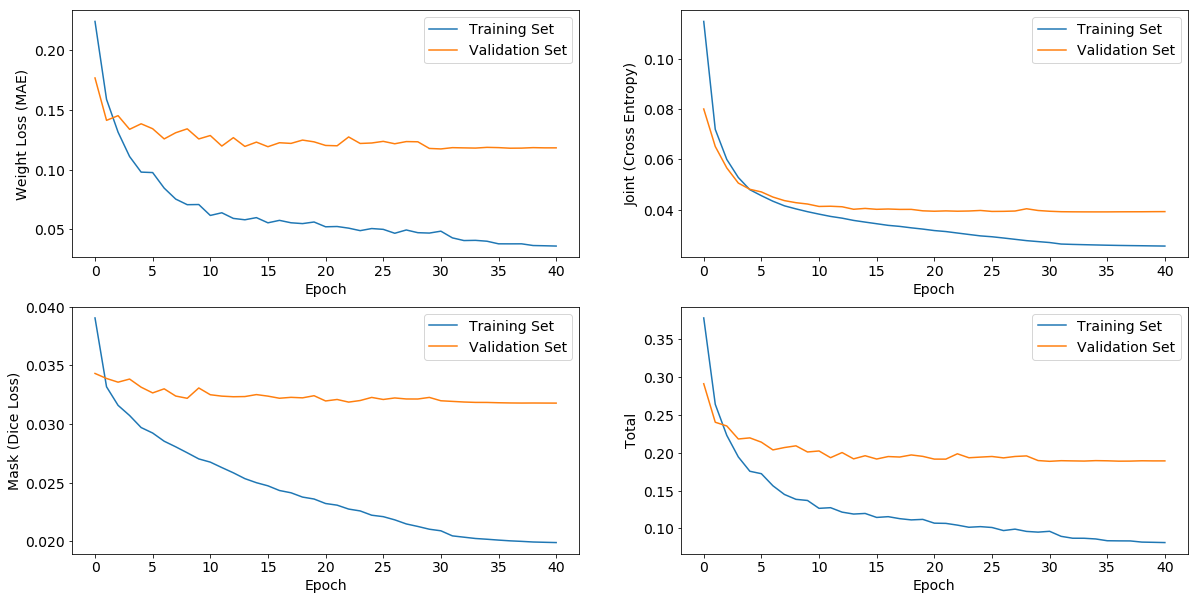

In [4]:
f, ax = plt.subplots(2,2, figsize=(20,10))
ax = ax.ravel()

labels = ['Weight Loss (MAE)', 'Joint (Cross Entropy)', 'Mask (Dice Loss)', 'Total']

for i, l in enumerate(glob('logs/IMDB_MODEL_WEIGHT_17102019_161323/t_*')):
    ax[i].plot(np.load(l), label='Training Set')
    ax[i].plot(np.load(l.replace('t_', 'v_')), label='Validation Set')
    ax[i].legend(fontsize=14)
    ax[i].set_ylabel(labels[i], fontsize=14)
    ax[i].set_xlabel('Epoch', fontsize=14)
    ax[i].tick_params(labelsize=14)

## Model Initialization

In [5]:
# Height
model_h = UNet_H(128)
pretrained_model = torch.load(glob('models/IMDB_MODEL_07102019_054512/*')[0])
model_h.load_state_dict(pretrained_model["state_dict"])

# Weight
model_w = UNet_W(128, 32, 32)
pretrained_model = torch.load(glob('models/IMDB_MODEL_WEIGHT_17102019_161323/*')[0])
model_w.load_state_dict(pretrained_model["state_dict"])

<All keys matched successfully>

## Enable CUDA

In [6]:
model_h = model_h.cuda()
#model_w = model_w.cuda()

## Height Estimation on Test Set

In [8]:
test = DataLoader(TestImages_Height(False, False), batch_size=1, num_workers=0, shuffle=False)

pred = []
real = []
errors = []

model_h.eval()
        
with torch.no_grad():
    with tqdm(total=len(test), dynamic_ncols=True) as progress:
        for idx, batch_data in enumerate(test):
            
            h_t = batch_data["height"].item()
            m_p, j_p, h_p = model_h(batch_data["img"].cuda())

            real.append(h_t)
            pred.append(h_p.item())
            
            progress.update(1)

real = np.array(real)
pred = np.array(pred)

print("Height Estimation error (MAE): {:.3f} cm".format(np.mean(abs(100*pred - real))))


Height Estimation error (MAE): 6.136 cm


## Weight Estimation on Test Set

In [8]:
test = DataLoader(TestImages_Weight(), batch_size=1, num_workers=0, shuffle=False)

pred = []
real = []
errors = []

model_w.eval()
        
with torch.no_grad():
    with tqdm(total=len(test), dynamic_ncols=True) as progress:
        for idx, batch_data in enumerate(test):
            
            w_t = batch_data["weight"].item()
            m_p, j_p, _, w_p = model_w(batch_data["img"].cuda())

            real.append(w_t)
            pred.append(w_p.item())
            
            progress.update(1)

real = np.array(real)
pred = np.array(pred)

print("Weight Estimation error (MAE): {:.1f} kg".format(np.mean(abs(100*pred - real))))


Weight Estimation error (MAE): 9.8 kg
